In [19]:
import thicket as th
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob
import numpy as np
import os
import sys
sys.path.append(
    "/scratch/group/csce-435-f25/python-3.10.8/lib/python3.10/site-packages")


pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)

In [22]:
cali_files = glob("cali-files/*.cali")
tk = th.Thicket.from_caliperreader(cali_files)
df = tk.dataframe.reset_index()
df_merged = df.merge(tk.metadata, left_on='profile', right_index=True)
df = df_merged[df_merged['data_type'] != 'float']

(2/2) Creating Thicket: 100%|██████████| 559/559 [00:08<00:00, 62.91it/s]


In [32]:
df_sorted = df.sort_values(by=['input_size', 'num_procs', 'data_type', 'input_type'])
df_sorted[(df_sorted['opts:output'] == 'cali-files/28-2-2-0.cali')
]

,node,profile,nid,spot.channel,Min time/rank,Max time/rank,Avg time/rank,Total time,Min time/rank (exc),Max time/rank (exc),Avg time/rank (exc),Total time (exc),Calls/rank (min),Calls/rank (avg),Calls/rank (max),Calls (total),name,cali.caliper.version,mpi.world.size,spot.metrics,spot.timeseries.metrics,spot.format.version,spot.options,spot.channels,cali.channel,opts:node.order,opts:output,opts:region.count,opts:time.exclusive,implementation_source,group_num,num_procs,input_type,input_size,size_of_data_type,data_type,programming_model,algorithm,cluster,cmdline,libraries,launchdate
280,"{'name': 'main', 'type': 'function'}",8275457548400,1.0,"(regionprofile,)",43.614000,46.804500,45.209300,90.418600,0.458851,0.461008,0.459930,0.919860,NaN,NaN,NaN,NaN,main,2.13.1,2,"min#inclusive#sum#time.duration,max#inclusive#...",,2,"node.order,region.count,time.exclusive",regionprofile,spot,true,cali-files/28-2-2-0.cali,true,true,https://stanford.edu/~rezab/classes/cme323/S16...,8,2,2,268435456,4,int,MPI,Merge Sort,c,"[./merge_sort, 28, 2, 0]","[linux-vdso.so.1, /scratch/group/csce-435-f25/...",1761620075
840,"{'name': 'data_init_runtime', 'type': 'function'}",8275457548400,2.0,"(regionprofile,)",7.923720,7.924670,7.924200,15.848400,7.923720,7.924670,7.924200,15.848400,1.0,1.0,1.0,2.0,data_init_runtime,2.13.1,2,"min#inclusive#sum#time.duration,max#inclusive#...",,2,"node.order,region.count,time.exclusive",regionprofile,spot,true,cali-files/28-2-2-0.cali,true,true,https://stanford.edu/~rezab/classes/cme323/S16...,8,2,2,268435456,4,int,MPI,Merge Sort,c,"[./merge_sort, 28, 2, 0]","[linux-vdso.so.1, /scratch/group/csce-435-f25/...",1761620075
1400,"{'name': 'comp', 'type': 'function'}",8275457548400,3.0,"(regionprofile,)",34.873500,37.094100,35.983800,71.967600,0.000060,0.000077,0.000069,0.000137,1.0,1.0,2.0,3.0,comp,2.13.1,2,"min#inclusive#sum#time.duration,max#inclusive#...",,2,"node.order,region.count,time.exclusive",regionprofile,spot,true,cali-files/28-2-2-0.cali,true,true,https://stanford.edu/~rezab/classes/cme323/S16...,8,2,2,268435456,4,int,MPI,Merge Sort,c,"[./merge_sort, 28, 2, 0]","[linux-vdso.so.1, /scratch/group/csce-435-f25/...",1761620075
1960,"{'name': 'comp_small', 'type': 'function'}",8275457548400,4.0,"(regionprofile,)",34.873500,35.058800,34.966100,69.932300,34.873500,35.058800,34.966100,69.932300,1.0,1.0,1.0,2.0,comp_small,2.13.1,2,"min#inclusive#sum#time.duration,max#inclusive#...",,2,"node.order,region.count,time.exclusive",regionprofile,spot,true,cali-files/28-2-2-0.cali,true,true,https://stanford.edu/~rezab/classes/cme323/S16...,8,2,2,268435456,4,int,MPI,Merge Sort,c,"[./merge_sort, 28, 2, 0]","[linux-vdso.so.1, /scratch/group/csce-435-f25/...",1761620075
2520,"{'name': 'comp_large', 'type': 'function'}",8275457548400,7.0,"(regionprofile,)",2.035180,2.035180,2.035180,2.035180,2.035180,2.035180,2.035180,2.035180,1.0,1.0,1.0,1.0,comp_large,2.13.1,2,"min#inclusive#sum#time.duration,max#inclusive#...",,2,"node.order,region.count,time.exclusive",regionprofile,spot,true,cali-files/28-2-2-0.cali,true,true,https://stanford.edu/~rezab/classes/cme323/S16...,8,2,2,268435456,4,int,MPI,Merge Sort,c,"[./merge_sort, 28, 2, 0]","[linux-vdso.so.1, /scratch/group/csce-435-f25/...",1761620075
3080,"{'name': 'comm', 'type': 'function'}",8275457548400,5.0,"(regionprofile,)",0.172375,0.357932,0.265153,0.530307,0.000023,0.000042,0.000033,0.000065,1.0,1.0,1.0,2.0,comm,2.13.1,2,"min#inclusive#sum#time.duration,max#inclusive#...",,2,"node.order,region.count,time.exclusive",regionprofile,spot,true,cali-files/28-2-2-0.cali,true,true,https://stanford.edu/~rezab/classes/cme323/S16...,8,2,2,268435456,4,int,MPI,Merge Sort,c,"[./merge_sort, 28, 2, 0]","[linux-vdso.so.1, /scratch/group/csce-435-f25/...",1761620075
3640,"{'name': 'comm_large', 'type': 'function'}",8275457548400,6.0,"(regionprofile,)",0.172352,0.357890,0.265121,0.530242,0.172352,0.357890,0.265121,0.530242,1.0,1.0,1.0,2.0,comm_large,2.13.1,2,"min#inclusive#sum#time.duration,max#inclusive#...

In [24]:
print(df['name'].unique())

['main' 'data_init_runtime' 'comp' 'comp_small' 'comp_large' 'comm'
 'comm_large' 'correctness_check']


In [25]:
print(tk.tree(metric_column="Avg time/rank"))

  _____ _     _      _        _   
 |_   _| |__ (_) ___| | _____| |_ 
   | | | '_ \| |/ __| |/ / _ \ __|
   | | | | | | | (__|   <  __/ |_ 
   |_| |_| |_|_|\___|_|\_\___|\__|  v2025.1.0

2.139 main
├─ 0.053 data_init_runtime
├─ 0.262 comp
│  ├─ 0.197 comp_small
│  └─ 0.129 comp_large
├─ 0.091 comm
│  └─ 0.091 comm_large
└─ 0.048 correctness_check

Legend (Metric: Avg time/rank Min: 0.05 Max: 2.14 indices: {'profile': np.int64(312997649)})
█ 1.93 - 2.14
█ 1.51 - 1.93
█ 1.09 - 1.51
█ 0.68 - 1.09
█ 0.26 - 0.68
█ 0.05 - 0.26

name User code    ◀  Only in left graph    ▶  Only in right graph



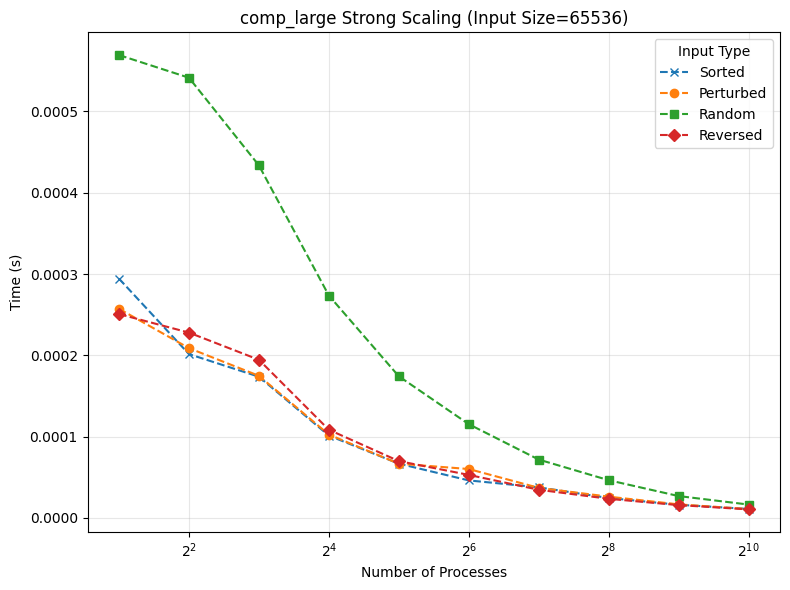

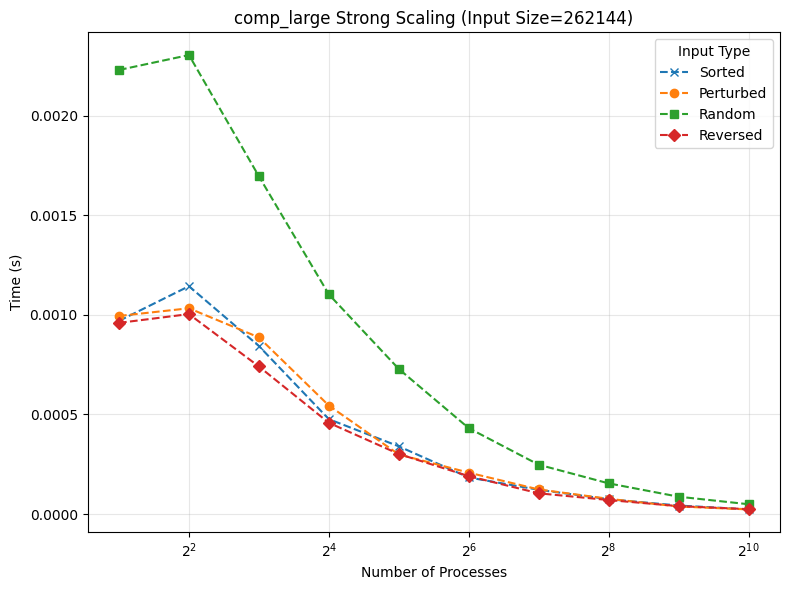

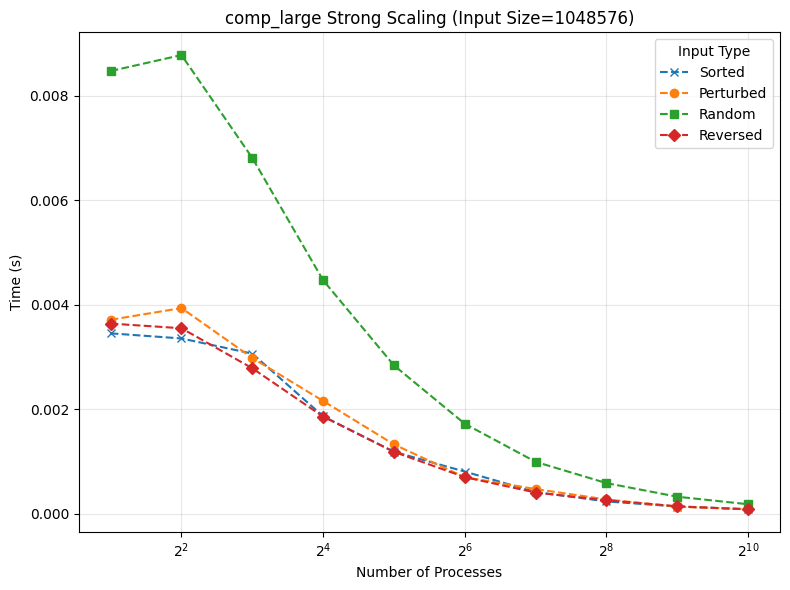

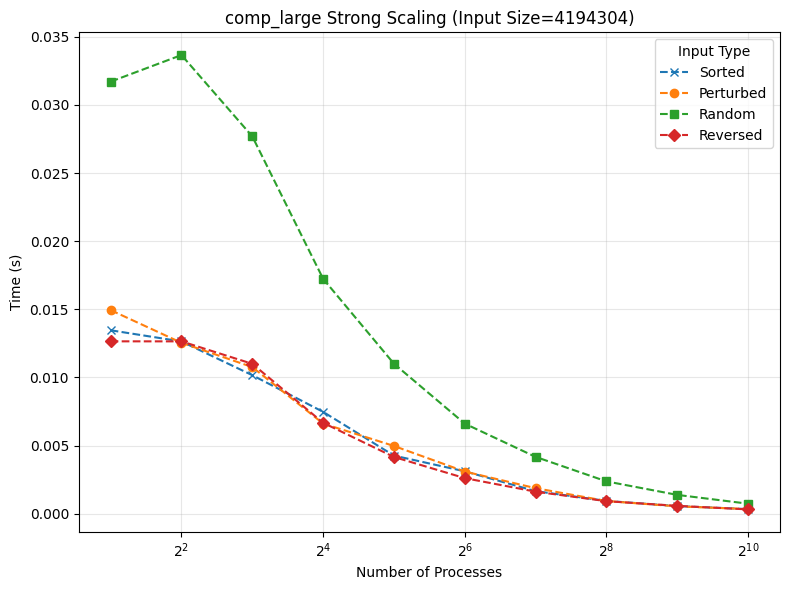

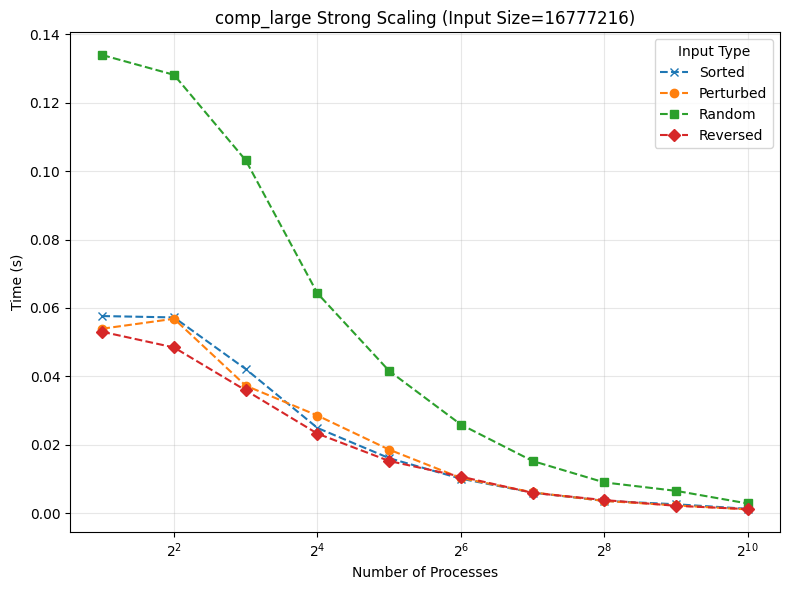

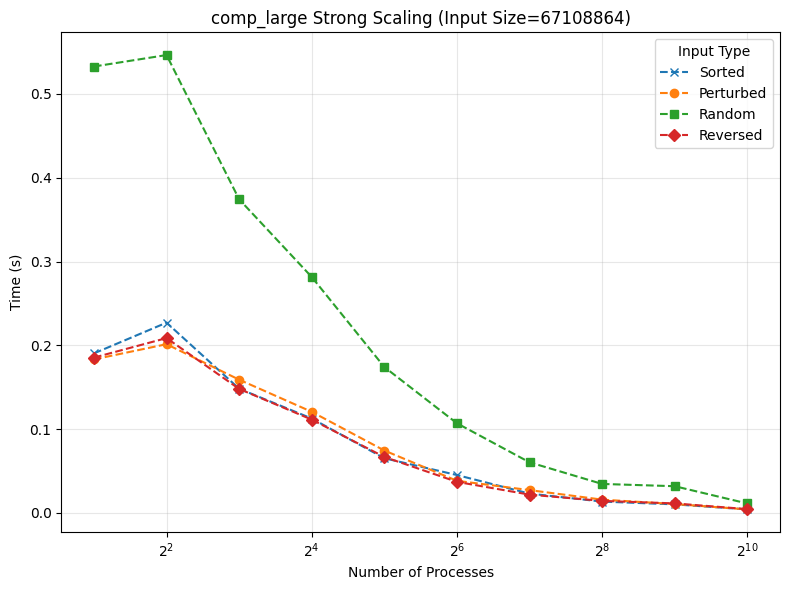

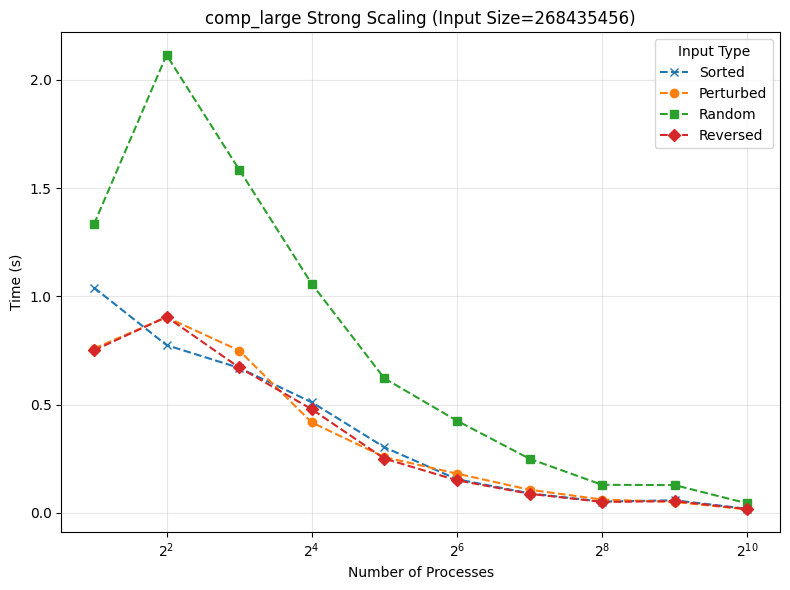

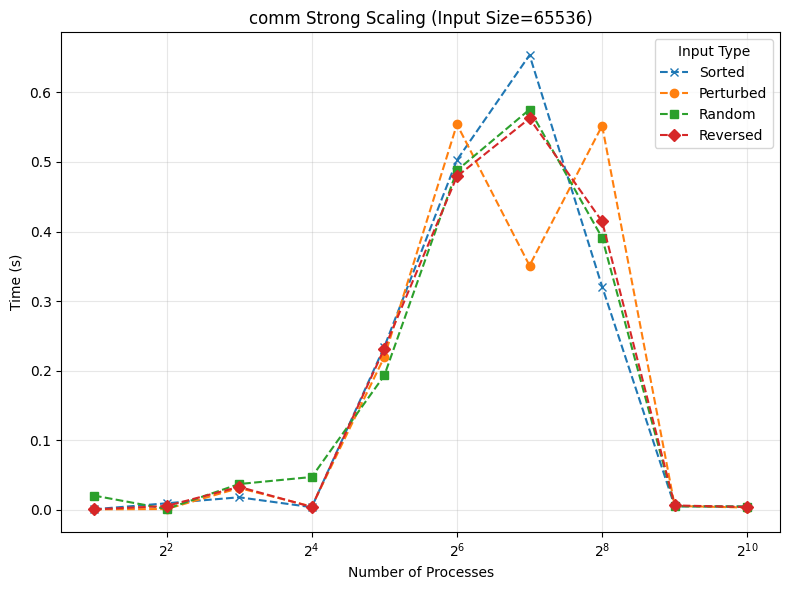

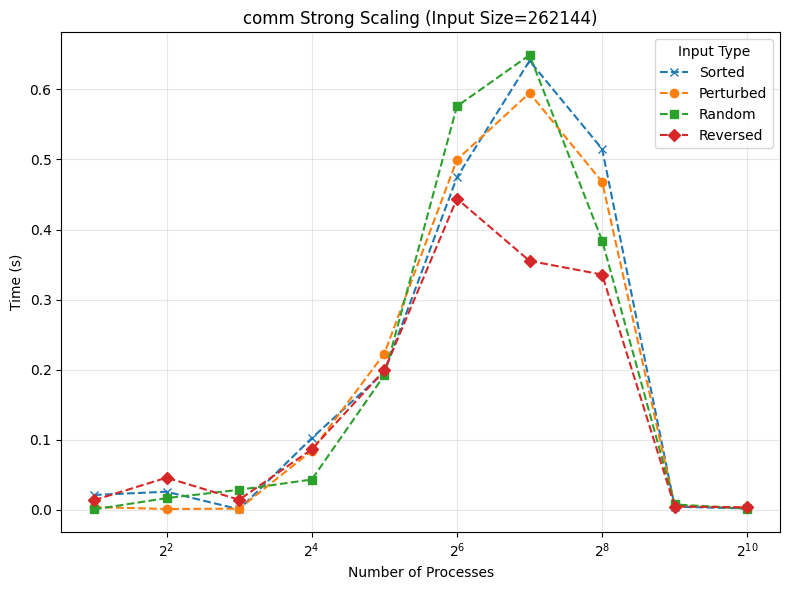

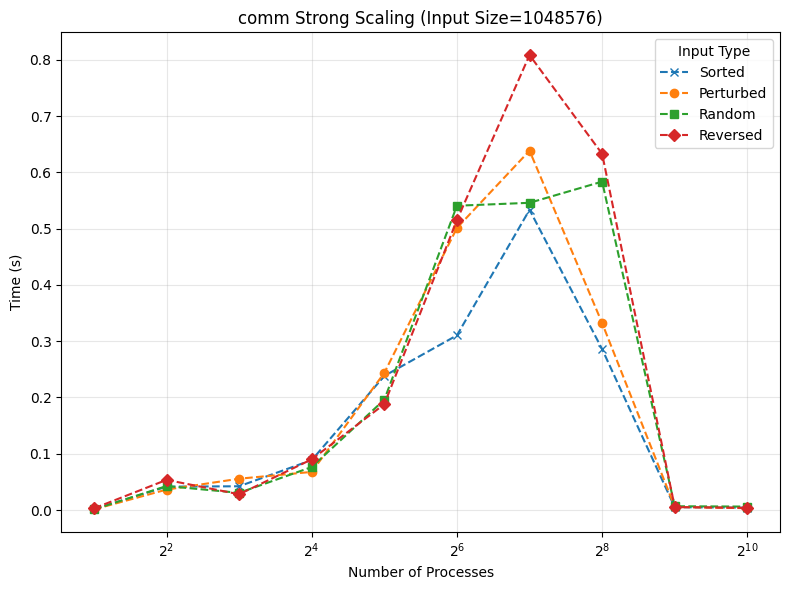

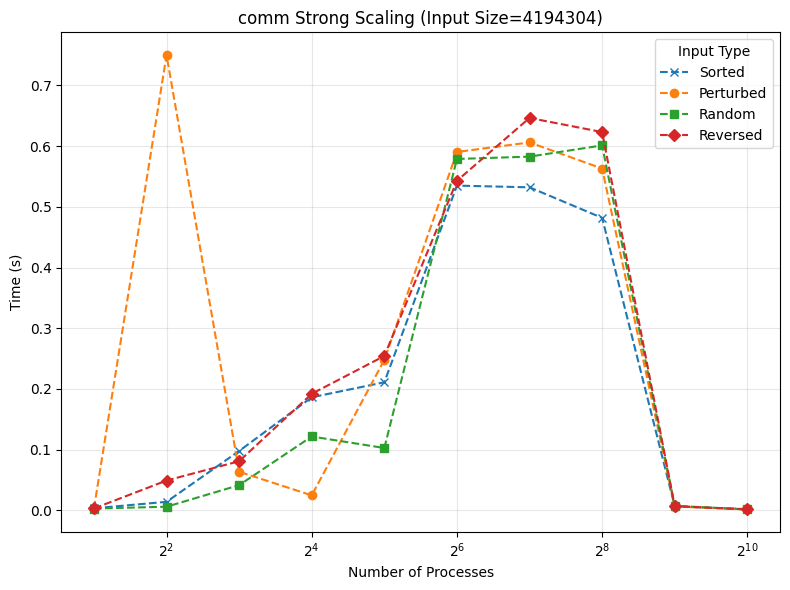

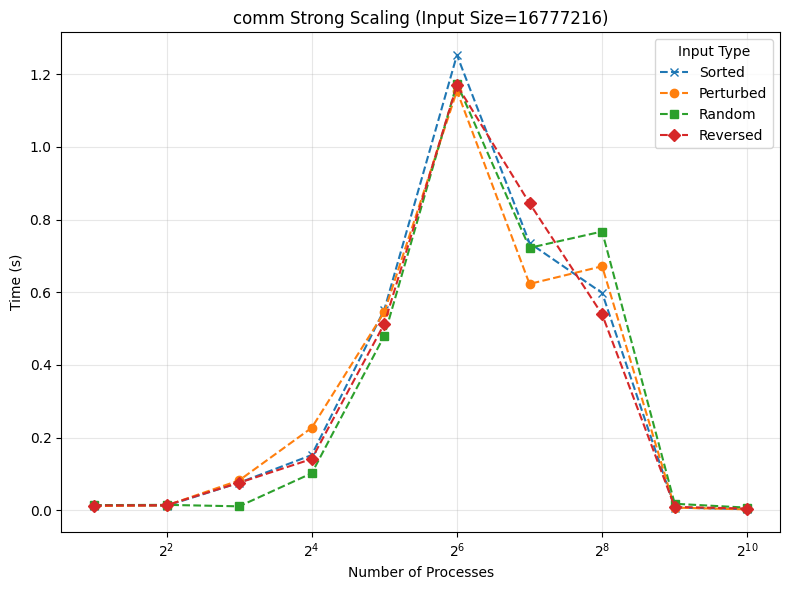

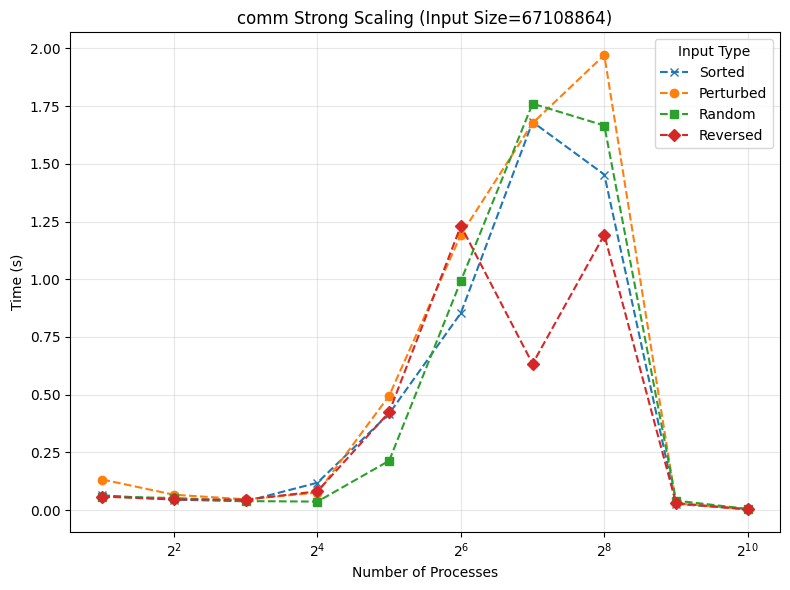

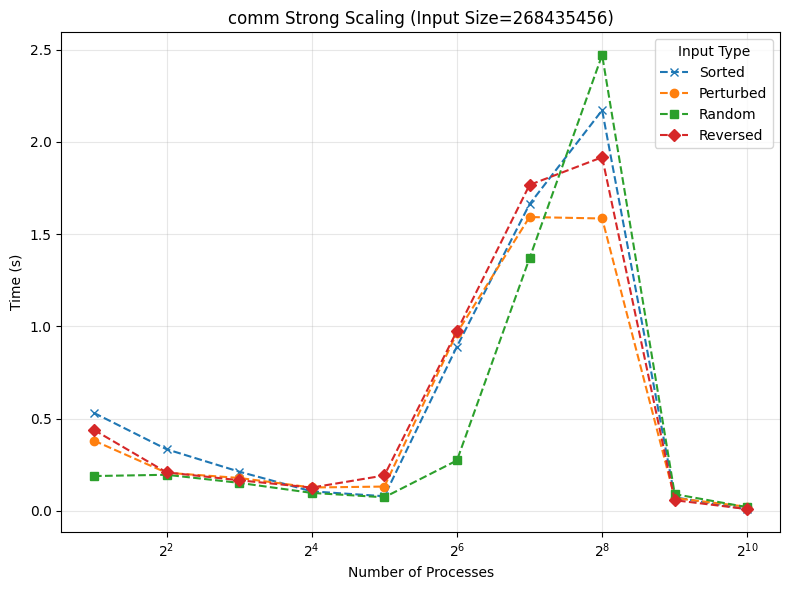

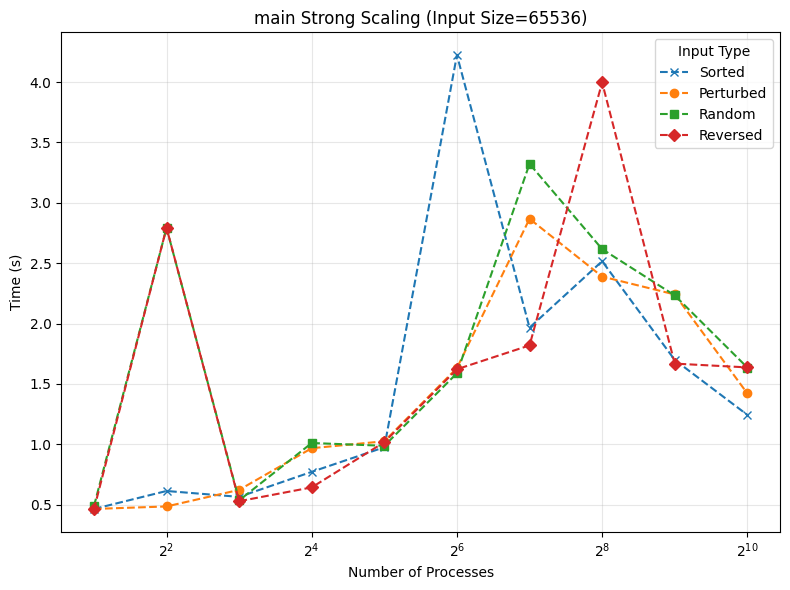

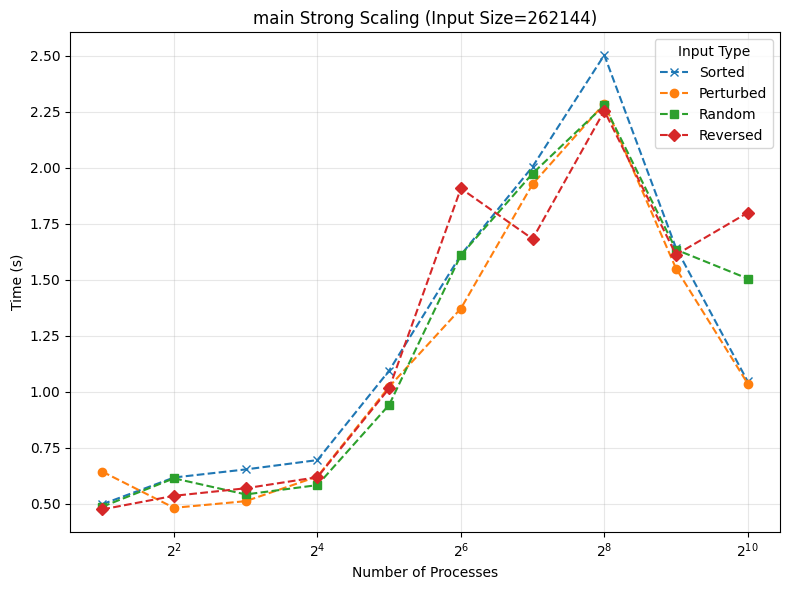

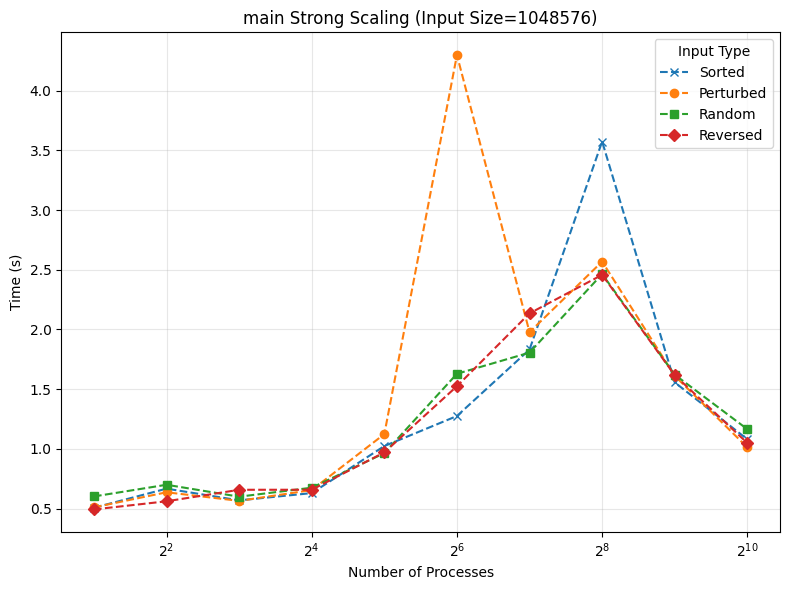

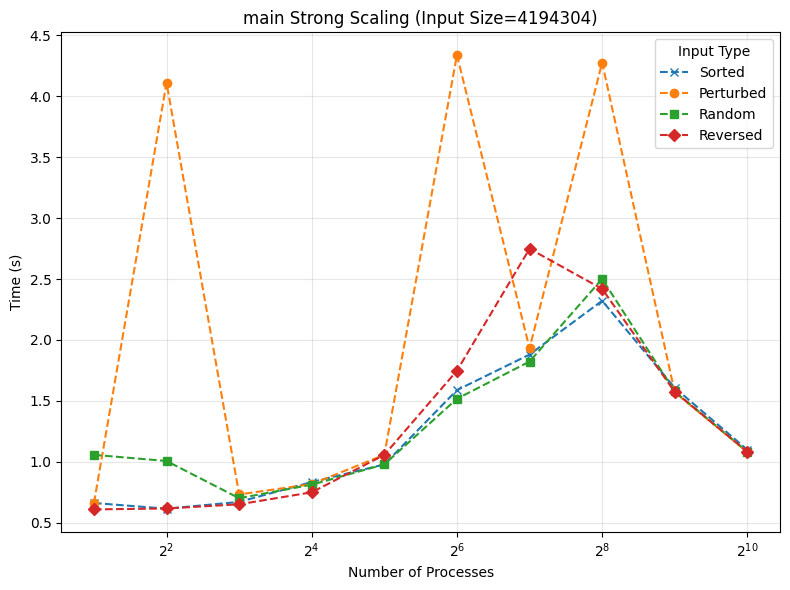

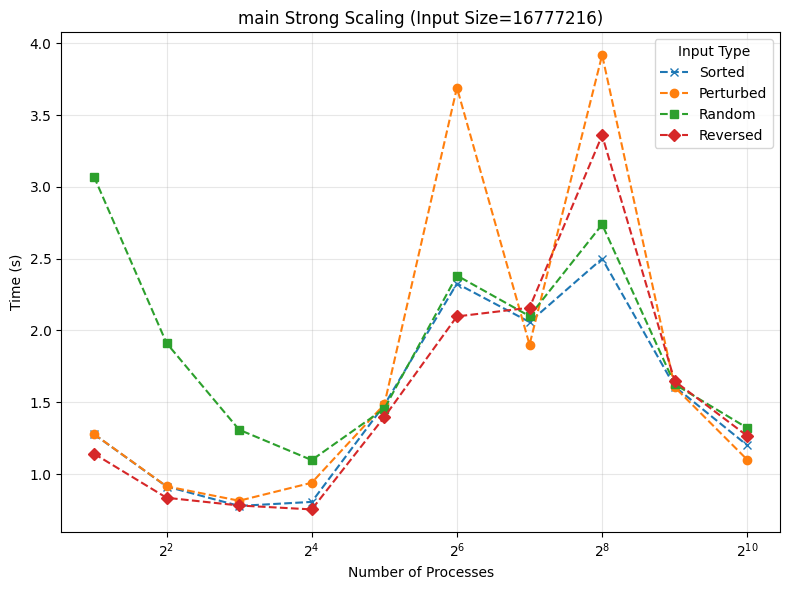

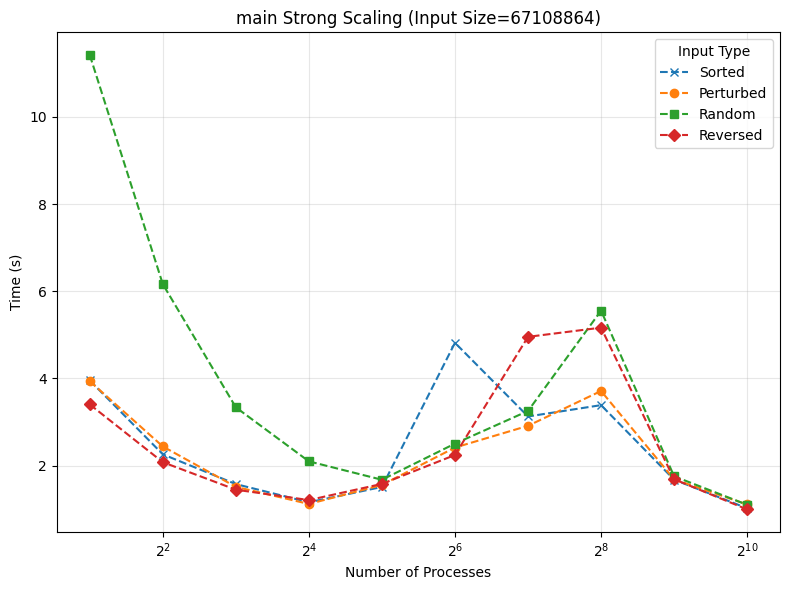

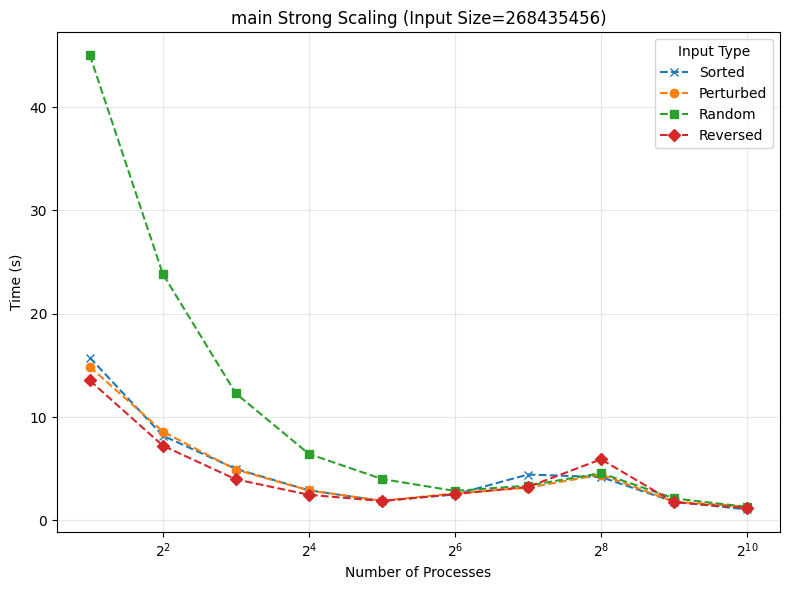

In [26]:
df = df_merged
regions = ['comp_large', 'comm', 'main']
input_types = [0, 1, 2, 3]
input_type_map = {0: 'Sorted', 1: 'Perturbed', 2: 'Random', 3: 'Reversed'}
input_sizes = [2**16, 2**18, 2**20, 2**22, 2**24, 2**26, 2**28]
num_procs_list = [2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]
weak_scaling_configs = [
    (2**16, 16), (2**18, 32), (2**20, 64),
    (2**22, 128), (2**24, 256), (2**26, 512), (2**28, 1024)
]
time_col = 'Avg time/rank' if 'Avg time/rank' in df.columns else 'time'
plt.style.use('default')
marker_list = ['x', 'o', 's', 'D']
line_styles = ['--', '--', '--', '--']

# 1. Strong scaling plots for each input_size
for region in regions:
    for input_size in input_sizes:
        fig, ax = plt.subplots(figsize=(8, 6))
        for idx, input_type in enumerate(input_types):
            times, procs = [], []
            for num_proc in num_procs_list:
                mask = (df['name'] == region) & \
                       (df['input_size'] == input_size) & \
                       (df['num_procs'] == num_proc) & \
                       (df['input_type'] == input_type)
                data = df[mask]
                if len(data) > 0:
                    times.append(data[time_col].iloc[0])
                    procs.append(num_proc)
            if len(times) > 0:
                ax.plot(procs, times, marker=marker_list[idx], linestyle=line_styles[idx],
                        label=input_type_map[input_type])
        ax.set_xlabel('Number of Processes')
        ax.set_ylabel('Time (s)')
        ax.set_title(f'{region} Strong Scaling (Input Size={input_size})')
        ax.set_xscale('log', base=2)
        ax.grid(True, alpha=0.3)
        ax.legend(title='Input Type', loc='best')
        plt.tight_layout()
        plt.savefig(
            f'strong-scaling/strong_scaling_{region}_input_size_{input_size}.png', dpi=150)
        plt.show()

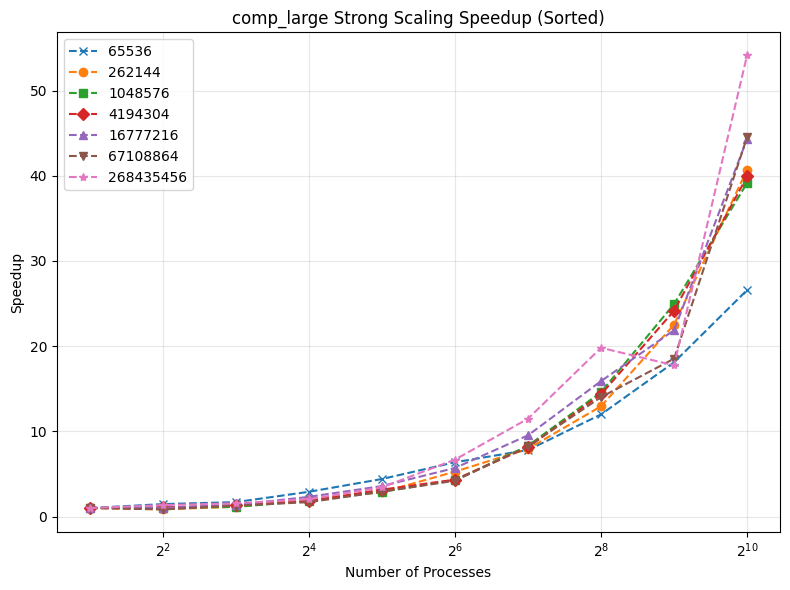

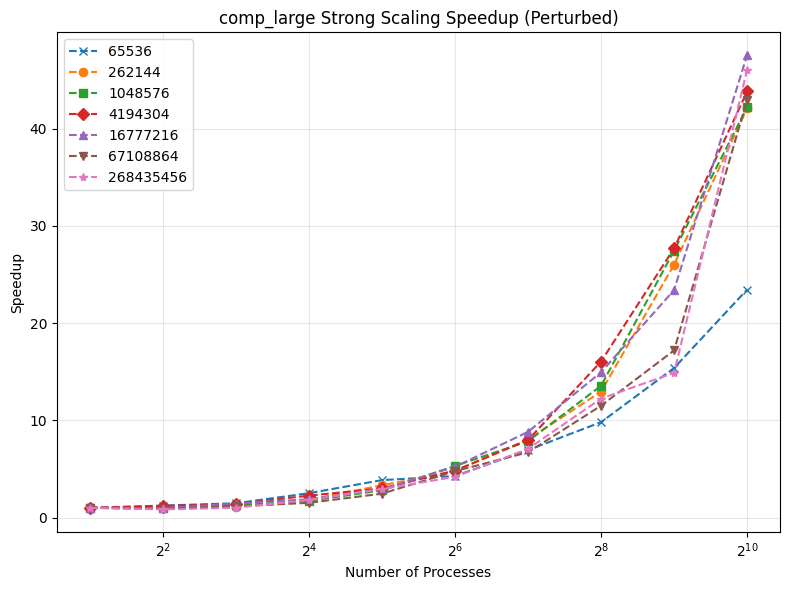

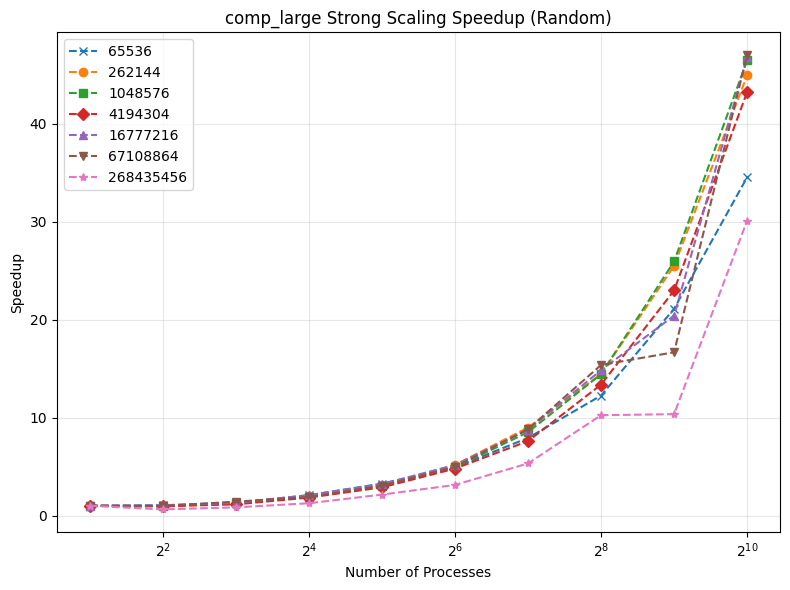

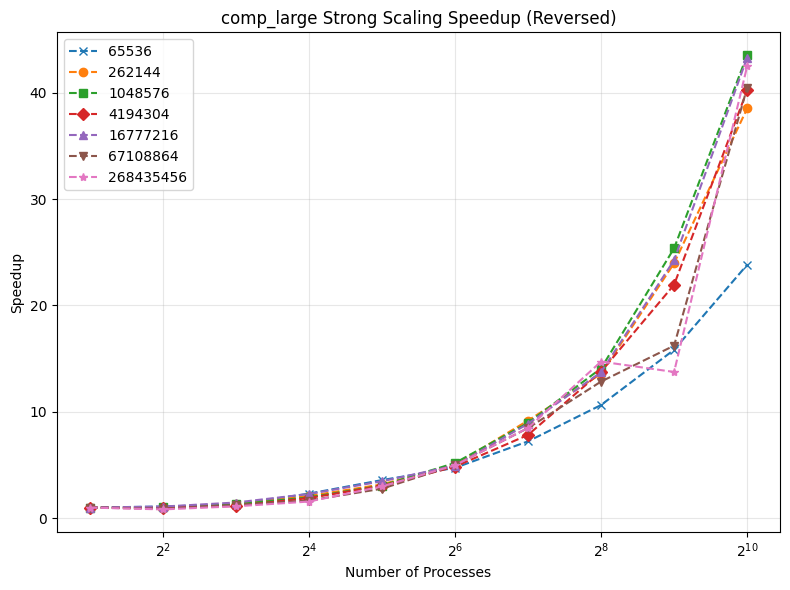

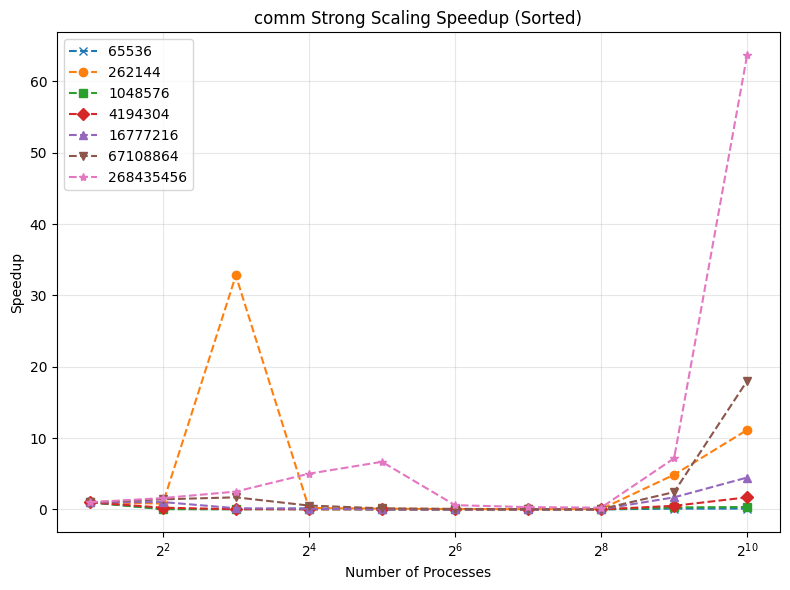

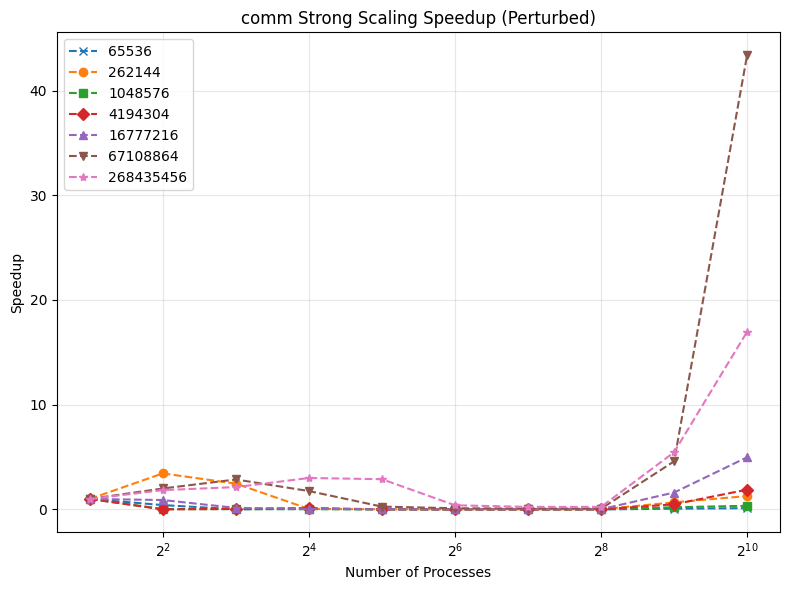

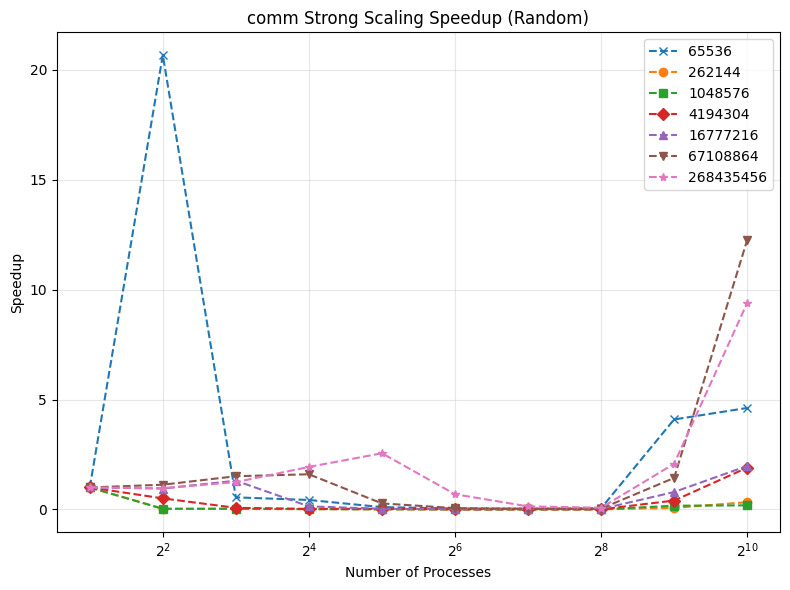

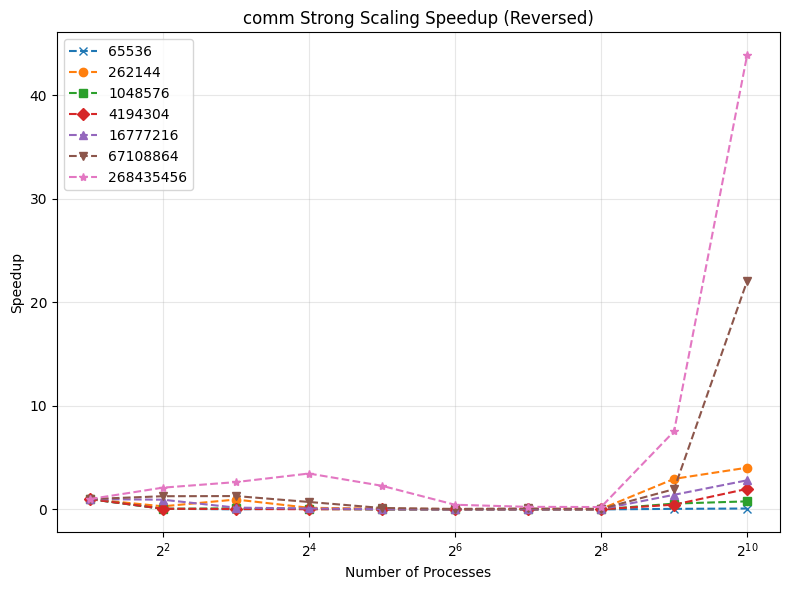

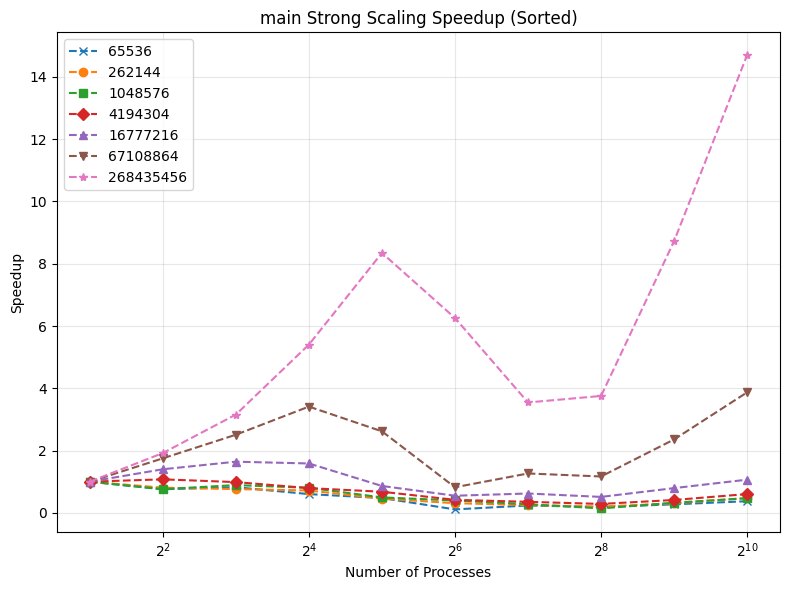

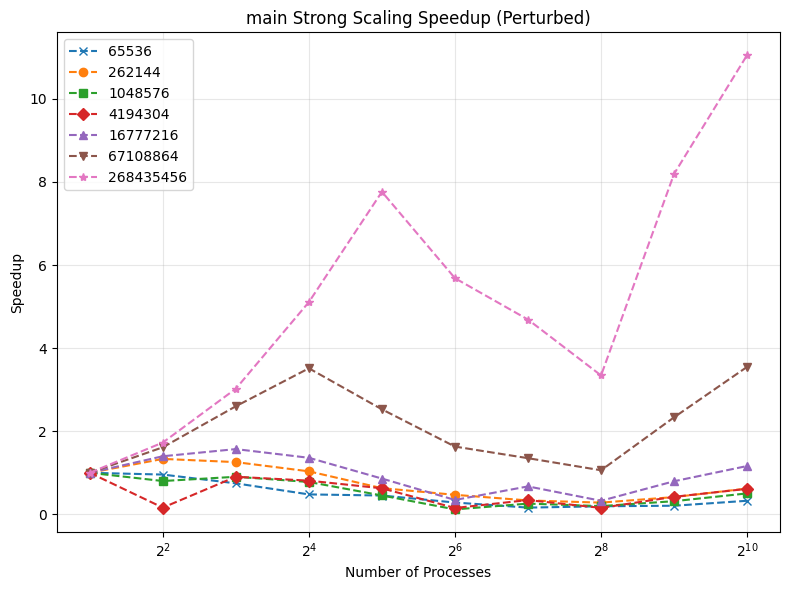

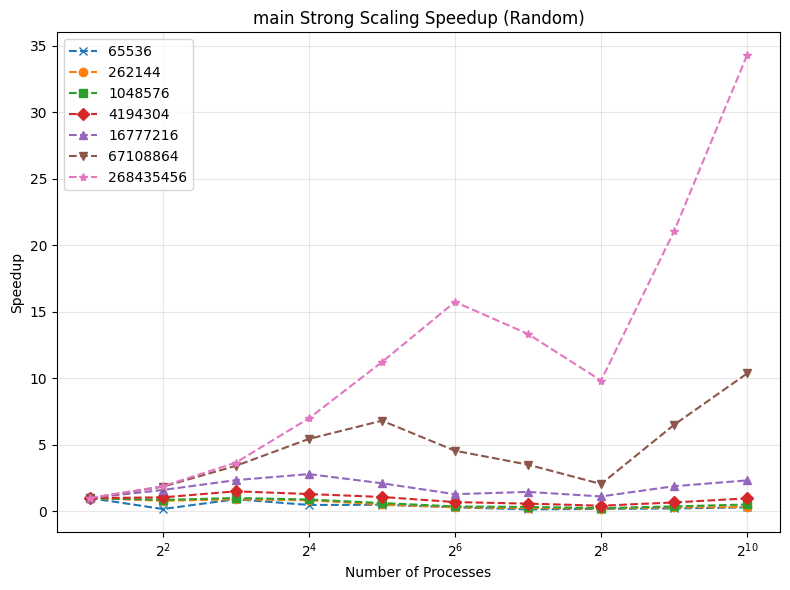

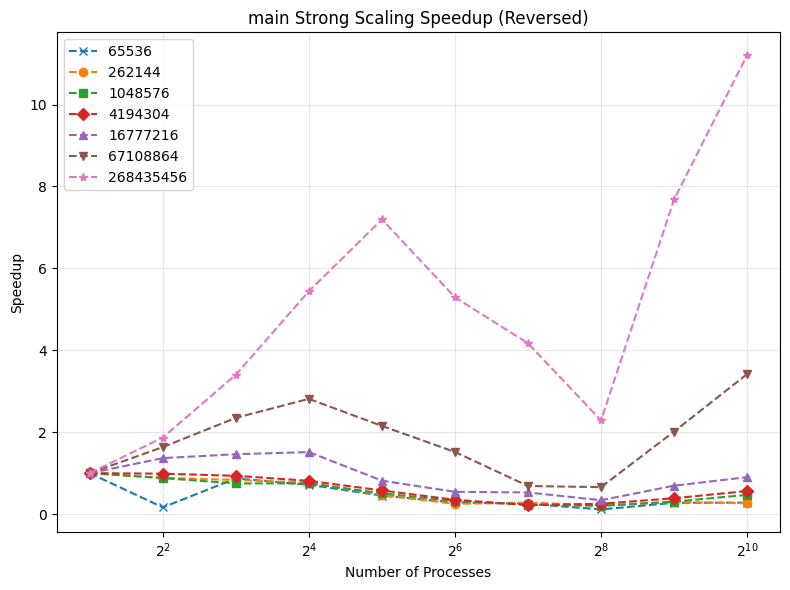

In [27]:
# 2. Strong scaling speedup plot for each input_type
time = ['Min time/rank', 'Max time/rank', 'Avg time/rank']
marker_list = ['x', 'o', 's', 'D','^','v','*']
line_styles = ['--', '--', '--', '--','--', '--', '--']
input_sizes = [2**16, 2**18, 2**20, 2**22, 2**24, 2**26, 2**28]
for region in regions:
    for idx, input_type in enumerate(input_types):
        fig, ax = plt.subplots(figsize=(8, 6))
        style = 0
        for fixed_size in input_sizes:
            times, procs = [], []
            for num_proc in num_procs_list:
                mask = (df['name'] == region) & \
                    (df['input_size'] == fixed_size) & \
                    (df['num_procs'] == num_proc) & \
                    (df['input_type'] == input_type)
                data = df[mask]
                if len(data) > 0:
                    times.append(data[time[2]].iloc[0])
                    procs.append(num_proc)
            if len(times) > 0:
                speedup = [times[0] / t for t in times]
                ax.plot(procs, speedup, marker=marker_list[style], linestyle=line_styles[style],
                        label=fixed_size)
            style += 1
        ax.set_xlabel('Number of Processes')
        ax.set_ylabel('Speedup')
        ax.set_title(
            f'{region} Strong Scaling Speedup ({input_type_map[input_type]})')
        ax.set_xscale('log', base=2)
        ax.grid(True, alpha=0.3)
        ax.legend(loc='best')
        plt.tight_layout()
        plt.savefig(
            f'strong-scaling-speedup/strong_scaling_speedup_{region}_input_type_{input_type_map[input_type]}.png', dpi=150)
        plt.show()

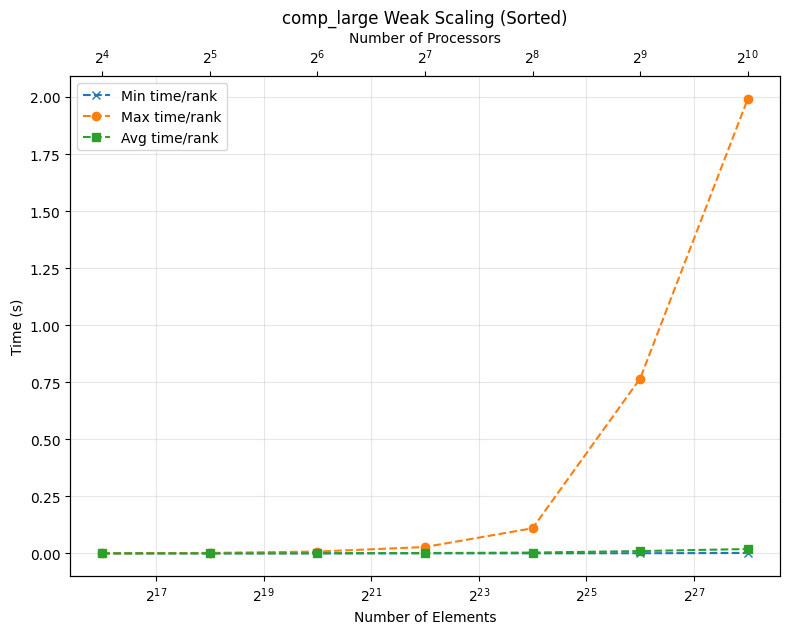

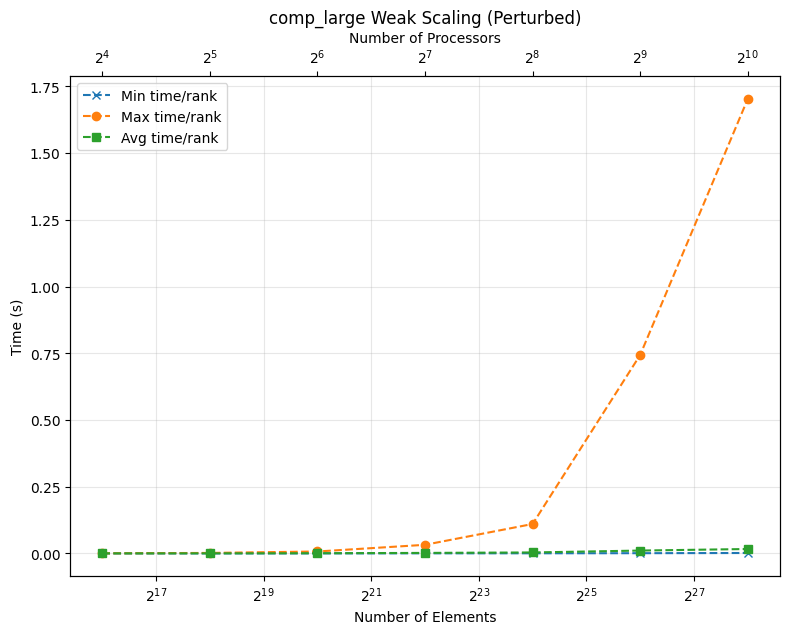

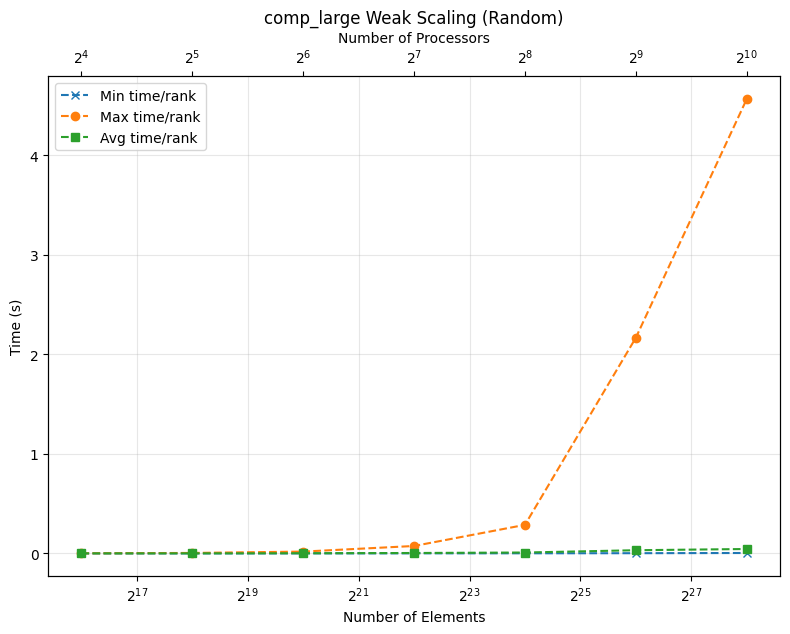

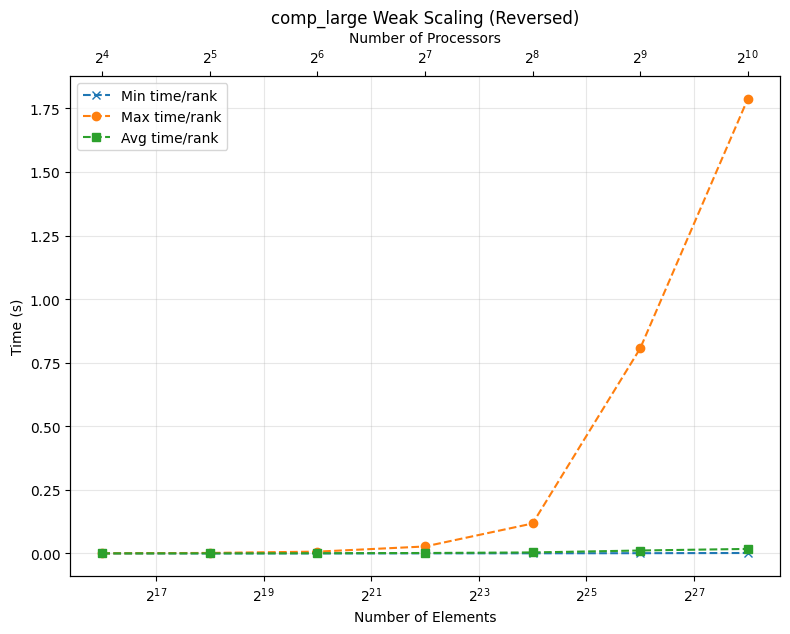

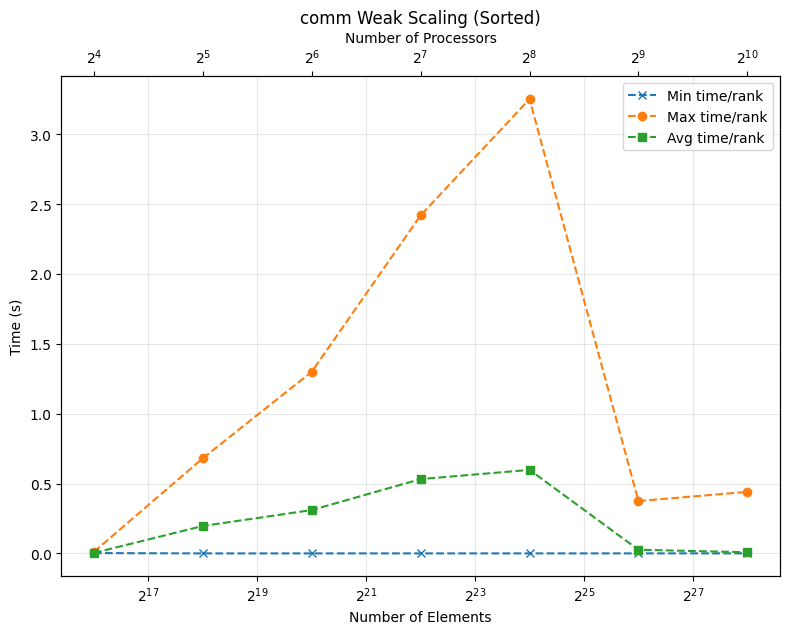

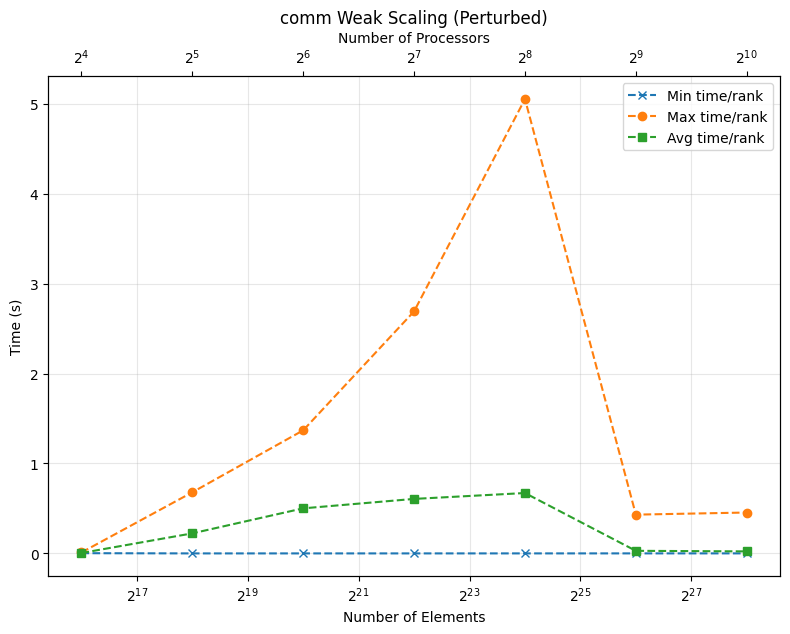

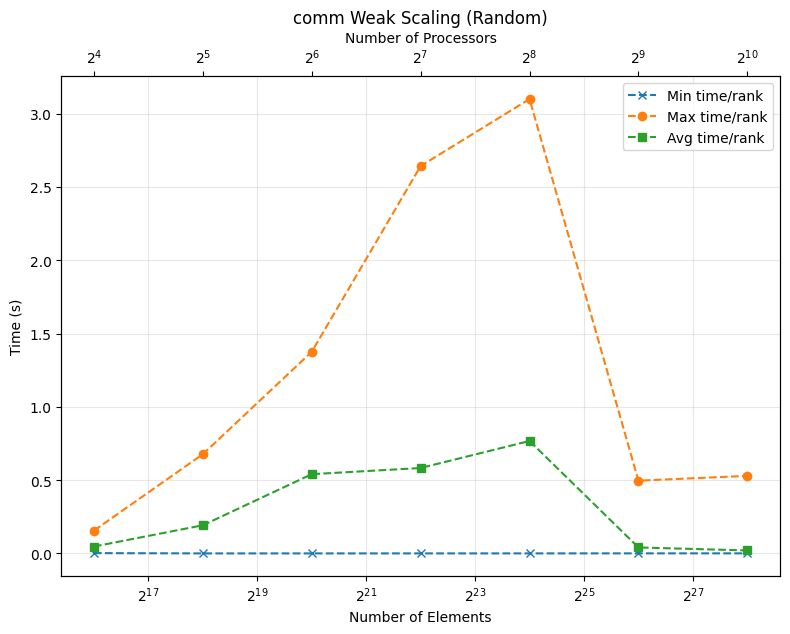

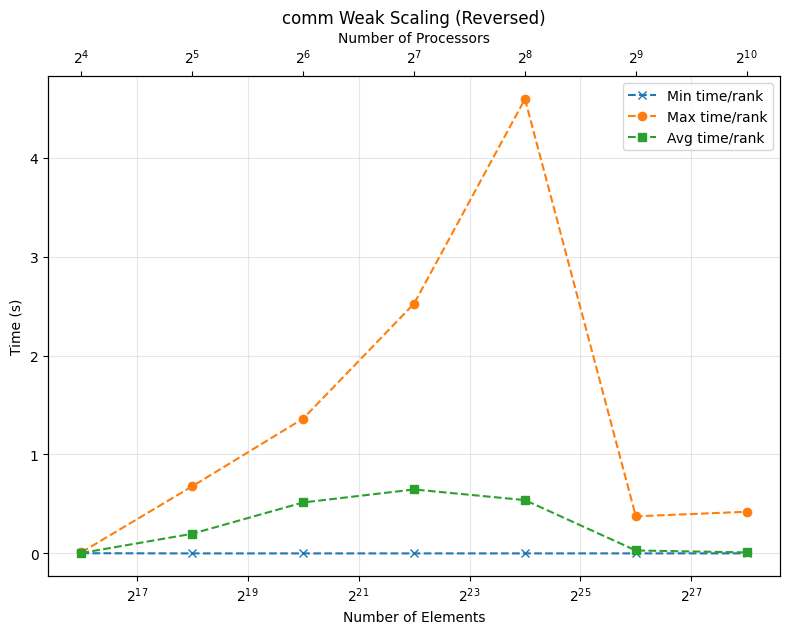

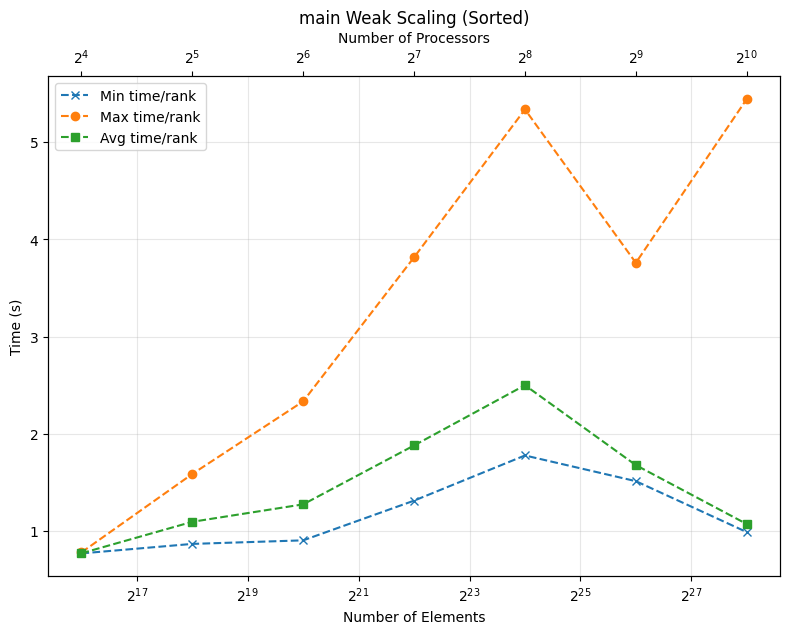

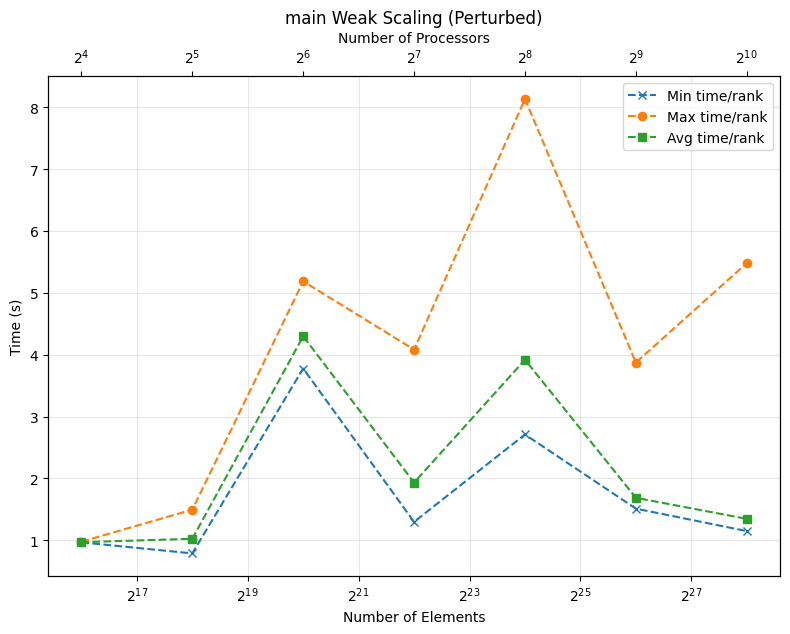

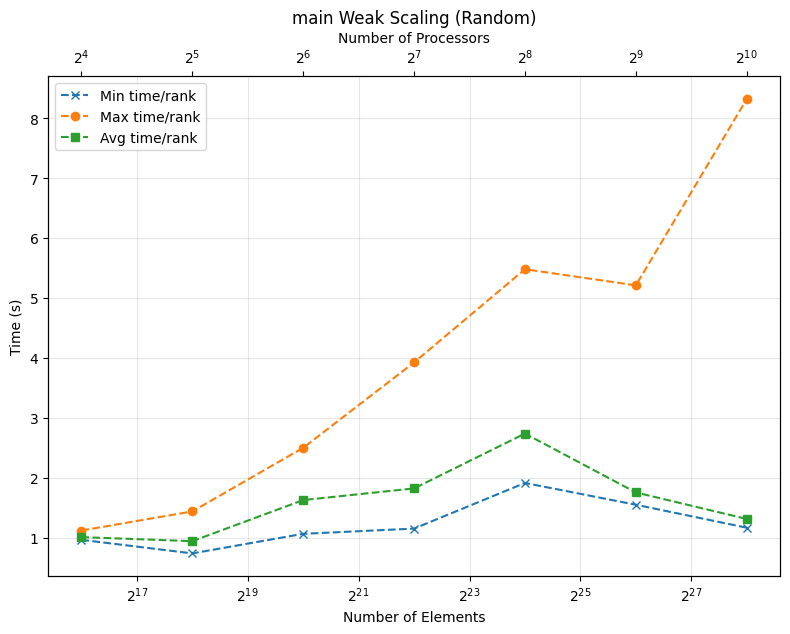

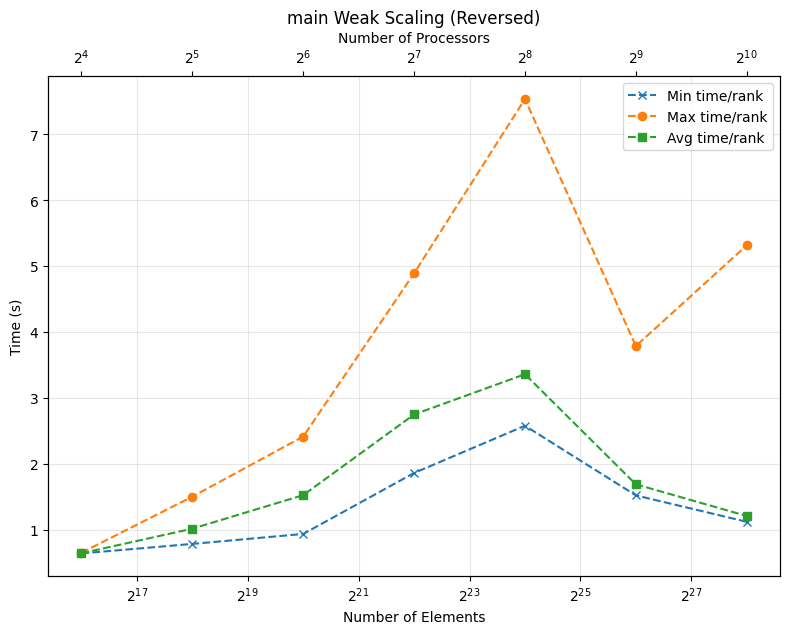

In [28]:
# 3. Weak scaling plots for each input_type
times_cols = ['Min time/rank', 'Max time/rank', 'Avg time/rank']
marker_list = ['x', 'o', 's', 'D']
line_styles = ['--', '--', '--', '--']
weak_scaling_procs = [16, 32, 64, 128, 256, 512, 1024]
num_of_elements = []
for region in regions:
    for idx, input_type in enumerate(input_types):
        fig, ax = plt.subplots(figsize=(8, 6))
        style = 0
        for t in times_cols:
            times = []
            num_of_elements = []
            
            for input_size, num_proc in weak_scaling_configs:
                mask = (
                    (df['name'] == region) &
                    (df['input_size'] == input_size) &
                    (df['num_procs'] == num_proc) &
                    (df['input_type'] == input_type) 
                )
                data = df[mask]
                if len(data) > 0:
                    times.append(data[t].iloc[0])
                    num_of_elements.append(input_size)
            if len(times) > 0:
                ax.plot(
                    num_of_elements,
                    times,
                    marker=marker_list[style],
                    linestyle=line_styles[style],
                    label=t
                )
            style+= 1
        ax.set_xlabel('Number of Elements')
        ax.set_ylabel('Time (s)')
        ax.set_title(f'{region} Weak Scaling ({input_type_map[input_type]})')
        ax.set_xscale('log', base=2)
        ax.grid(True, alpha=0.3)
        ax.legend(loc='best')
        plt.tight_layout()
        ax_top = ax.twiny()
        ax_top.set_xlim(ax.get_xlim())
        ax_top.set_xscale('log', base=2)
        ax_top.set_xticks(num_of_elements)
        ax_top.set_xticklabels([f"$2^{{{int(np.log2(p))}}}$" for p in weak_scaling_procs])
        ax_top.set_xlabel('Number of Processors')
        plt.savefig(
            f'weak-scaling/weak_scaling_{region}_input_type_{input_type_map[input_type]}.png',
            dpi=150,
            bbox_inches='tight'
        )
        plt.show()